In [80]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

In [10]:
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange', 
    'drug': 'tab:green',
    'cytokine': 'tab:olive'
}
SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'

# Load data

In [55]:
# get indecs of dataset
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name.split('.h5')[0]] = os.path.join(path, name)
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
datasets = list(h5_files.keys())
print(len(datasets))

35


In [12]:
sorted(datasets)

['AdamsonWeissman2016_GSM2406675_10X001',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AissaBenevolenskaya2021',
 'ChangYe2021',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'DixitRegev2016',
 'FrangiehIzar2021_RNA',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'GasperiniShendure2019_lowMOI',
 'GehringPachter2019',
 'McFarlandTsherniak2020',
 'NormanWeissman2019_filtered',
 'PapalexiSatija2021_eccite_RNA',
 'PapalexiSatija2021_eccite_arrayed_RNA',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'SchiebingerLander2019_GSE106340',
 'SchiebingerLander2019_GSE115943',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'ShifrutMarson2018',
 'SrivatsanTrapnell2020_sciplex2',
 'SrivatsanTrapnell2020_sciplex3',
 'SrivatsanTrapnell2020_sciplex4',
 'TianKampmann2019_day7neuron',
 'TianKampmann2019_iPSC'

In [83]:
cool_ones = ['PapalexiSatija2021_eccite_RNA', 'TianKampmann2021_CRISPRa', 'TianKampmann2021_CRISPRi', 'NormanWeissman2019_filtered',
       'SrivatsanTrapnell2020_sciplex3', 'DixitRegev2016', 'DatlingerBock2017', 'FrangiehIzar2021_RNA',
       'TianKampmann2019_day7neuron', 'TianKampmann2019_iPSC', 'ReplogleWeissman2022_K562_essential', 'ReplogleWeissman2022_rpe1'
      ]

# Compute statistics

In [82]:
# get info from obs (takes half a minute)
obses = {}
for name, path in tqdm(h5_files.items(), leave=False):
    obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv')
cat_obs_keys = ['perturbation_type', 'organism', 'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype']  # cat vector with a single value (ideally)
B=pd.DataFrame({name: [list(pd.unique(obs[key]))[0] if key in obs.keys() else None for key in cat_obs_keys] for name, obs in obses.items()}, index=cat_obs_keys).T

In [32]:
dfs = {}
for key in cool_ones:# h5_files.keys():
    # load pca and bulk pca pairwise distances
    pwd = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)

    # derive basic statistics
    sigmas = np.diag(pwd)
    std = np.sqrt(sigmas/2)
    deltas = pwd.loc[:, 'control']

    # aggregate
    perturbations = pwd.index
    df = pd.DataFrame([sigmas, std, deltas], index=['sigma', 'std', 'delta'], columns=perturbations).T
    df.index.name = 'perturbation'
    df['dataset'] = key

    # normalized statistics (divide by spread of the unperturbed cells)
    df['dps'] = df['delta'] / df.loc['control', 'sigma']
    df['sps'] = df['sigma'] / df.loc['control', 'sigma']
    df['stdpstd'] = df['std'] / df.loc['control', 'std']
    df['estat'] = 2 * df['delta'] - df['sigma'] - df.loc['control', 'sigma']
    df['fraction'] = df['delta']**2 / (df.loc['control', 'sigma'] * df['sigma'])

    dfs[key]=df

# merge
tab = pd.concat(dfs.values())
tab.head()

# add info
tab = pd.merge(tab, B, right_index=True, left_on='dataset')

# manual corrections
tab.loc[tab.dataset=='TianKampmann2021_CRISPRi', 'perturbation_type'] = 'CRISPRi'
tab.loc[tab.dataset=='TianKampmann2021_CRISPRa', 'perturbation_type'] = 'CRISPRa'
tab['dataset_'] = tab.dataset.copy()
tab.dataset_ = [x.replace('TAP_SCREEN__', '') for x in tab.dataset_]
tab.dataset_ = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in tab.dataset_]
tab.dataset_ = [x.replace('_', ' ') for x in tab.dataset_]
tab = tab.sort_values('dataset_')

# Estats over datasets

In [84]:
pairs_datasets = {}
estats_datasets = {}
for key in cool_ones:# h5_files.keys():
    print(key)
    # load pca and bulk pca pairwise distances
    pwd = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)

    # derive basic statistics
    sigmas = np.diag(pwd)
    deltas = pwd
    
    estats = 2 * deltas - sigmas - sigmas[:, np.newaxis]
    estats = cluster_matrix(estats, 'both')
    estats_control = estats.loc[:, 'control']
    
    # select unique combination pairs (since estats matrix is symmetric)
    U = pd.DataFrame(np.triu(estats, k=0), index=estats.index, columns=estats.columns)
    P = U.stack().reset_index()
    pairs = P[P[0]!=0]
    assert len(pairs[pairs[0]!=0]) * 2 + len(estats) == len(P)
    pairs['dataset'] = key
    
    estats_datasets[key] = estats
    pairs_datasets[key] = pairs

pairs_all = pd.concat(pairs_datasets)
pairs_all['E-statistic'] = ['perturbed-unperturbed' if 'control' in x+y else 'perturbed-perturbed' for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
pairs_all['pair'] = [x+'-'+y for x,y in zip(pairs_all.level_0, pairs_all.level_1)]
pairs_all['dataset_pretty'] = [x.replace('_', '\n', 1) for x in pairs_all.dataset]
pairs_all.index = pairs_all.index.droplevel(level=1)

PapalexiSatija2021_eccite_RNA
TianKampmann2021_CRISPRa
TianKampmann2021_CRISPRi
NormanWeissman2019_filtered
SrivatsanTrapnell2020_sciplex3
DixitRegev2016
DatlingerBock2017
FrangiehIzar2021_RNA
TianKampmann2019_day7neuron
TianKampmann2019_iPSC
ReplogleWeissman2022_K562_essential
ReplogleWeissman2022_rpe1


In [111]:
# add info on pert type for hue
pairs_all['perturbation_type']=None
for dataset in pd.unique(pairs_all.index.get_level_values(0)):
    pairs_all.loc[dataset, 'perturbation_type'] = B.loc[dataset, 'perturbation_type']

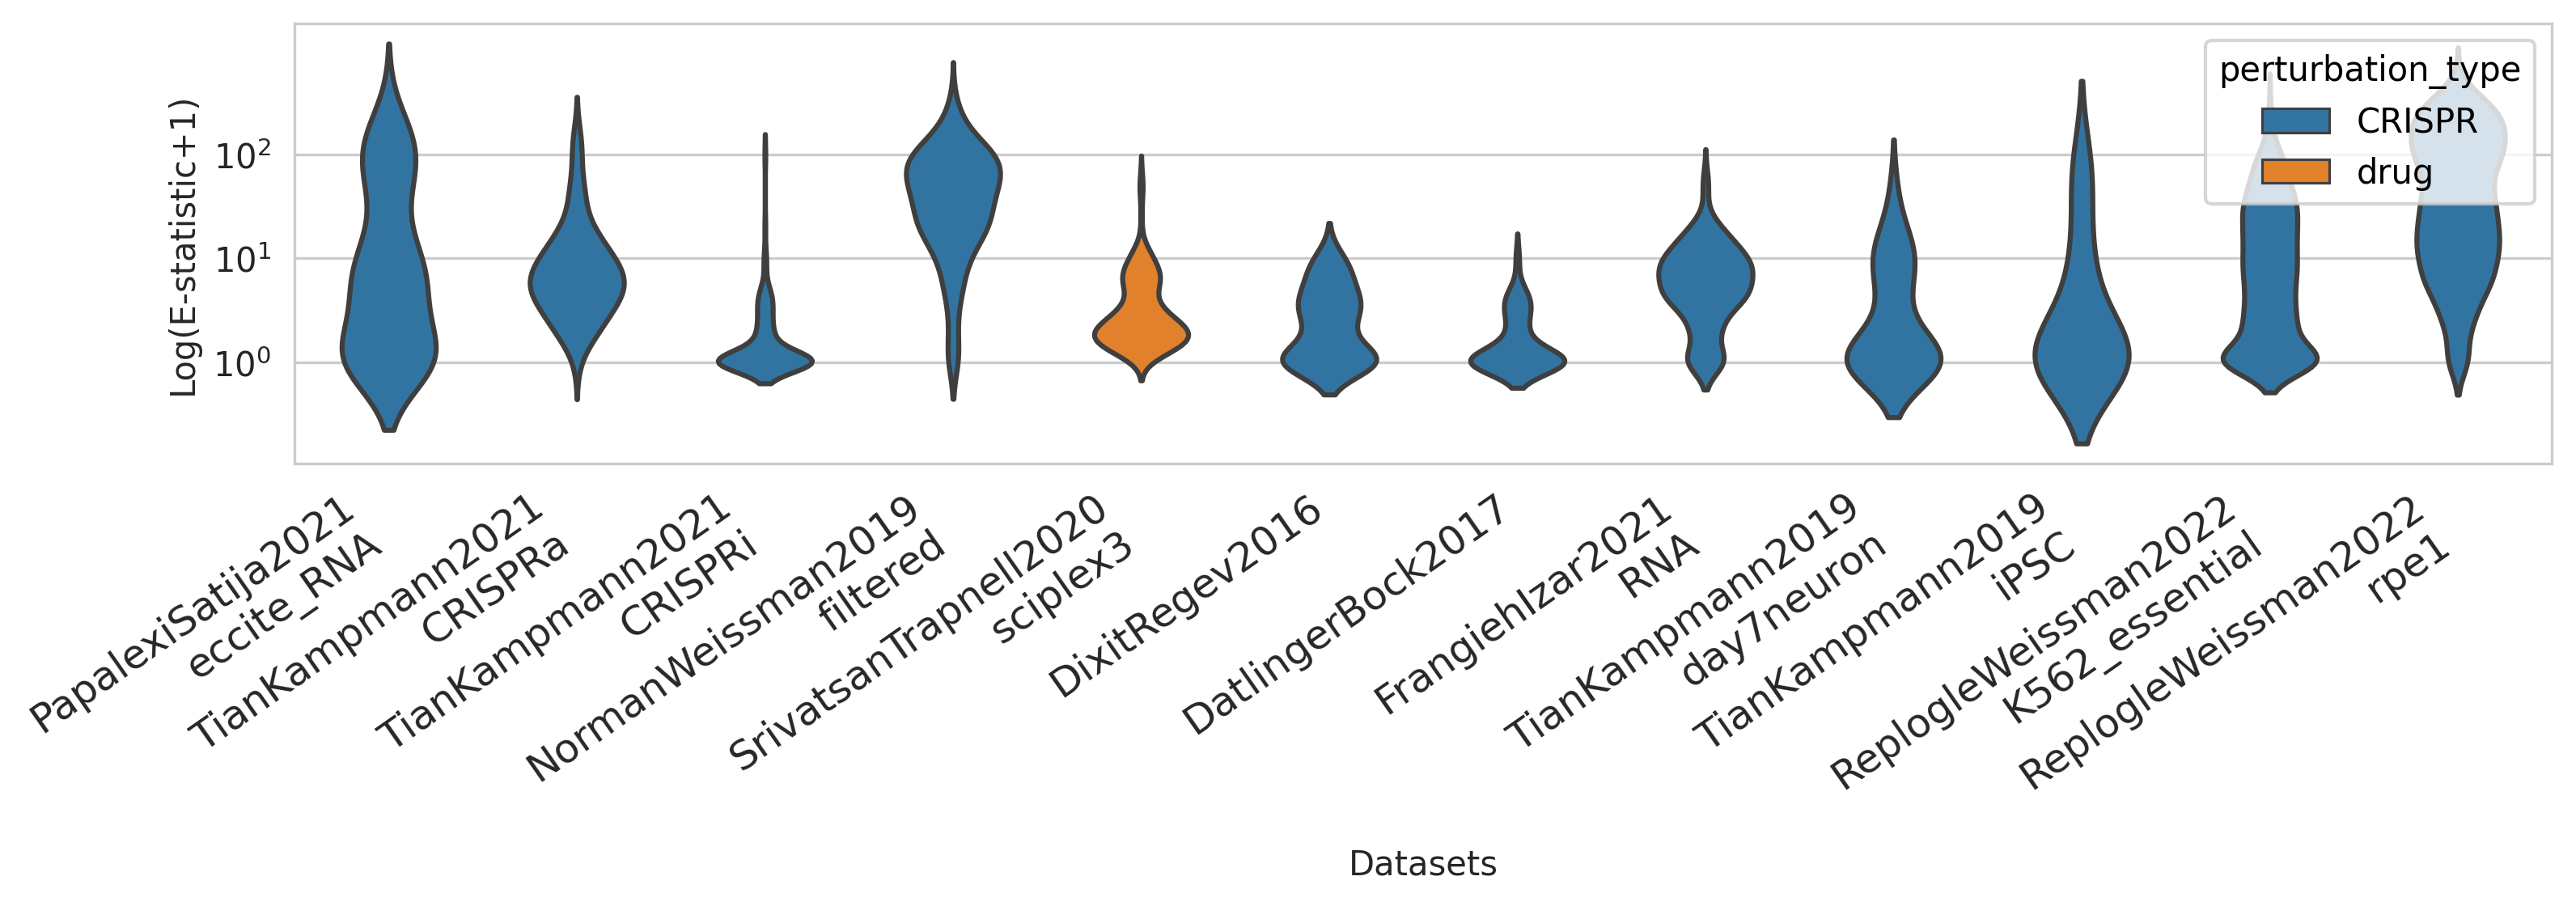

In [113]:
scale = 0.6
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 4*scale], dpi=300)
pairs_all['tmp'] = np.log10(np.clip(pairs_all[0],0, np.infty)+1)
sns.violinplot(data=pairs_all[pairs_all['E-statistic']=='perturbed-unperturbed'], x='dataset_pretty', y='tmp', width=0.5, inner=None,
               hue='perturbation_type', dodge=False
              )
pl.xticks(rotation=35, ha='right', fontsize=12)
pl.ylabel('Log(E-statistic+1)')
pl.xlabel('Datasets')
# pl.xlim([-1.5,5])

# log scale y ticks
from matplotlib import ticker as mticker
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(0, 3)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
# ax.set_ylim([-0.4, 1.4])

pl.savefig('../../figures/violin_estatistics_horizontal.pdf', bbox_inches='tight')
pl.show()

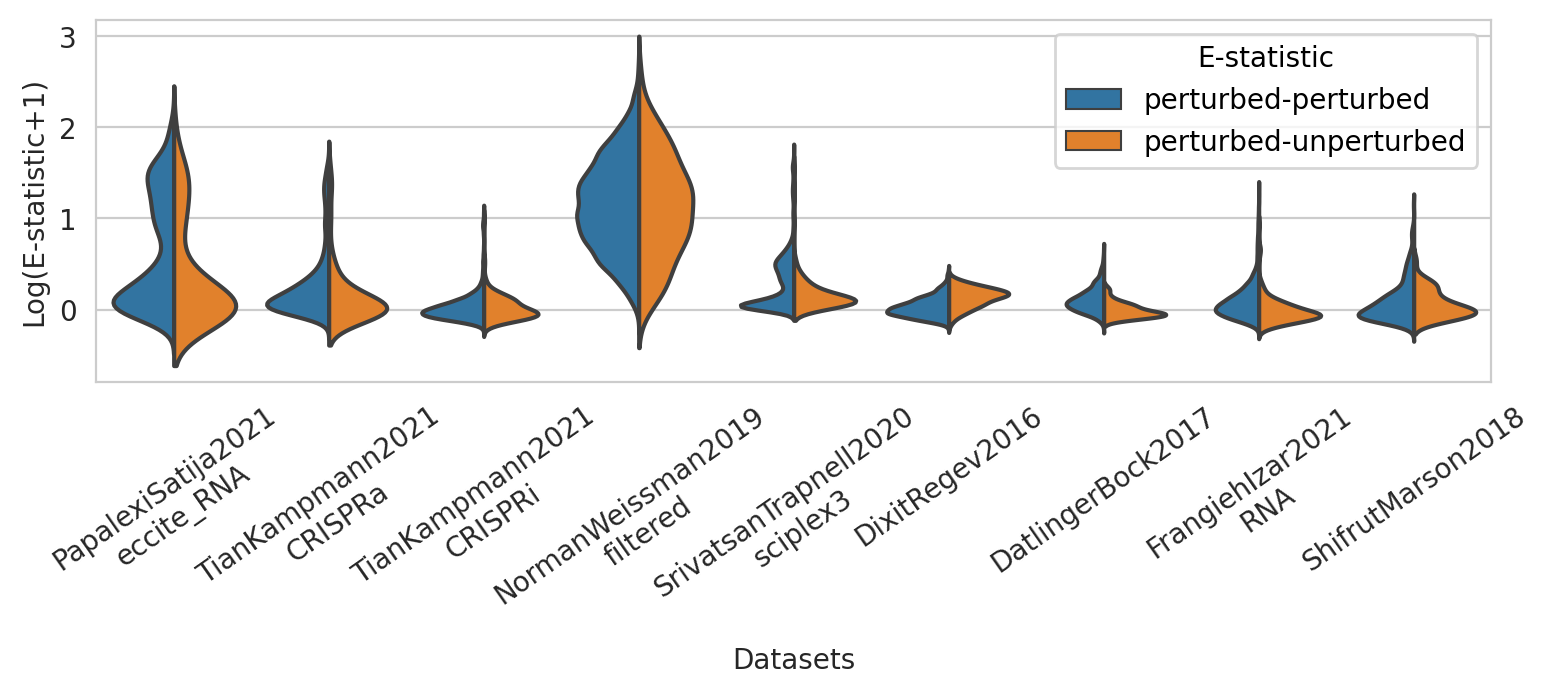

In [715]:
scale = 0.6
with sns.axes_style('whitegrid'):
    pl.subplots(figsize=[15*scale, 4*scale], dpi=200)
pairs_all['tmp'] = np.log(pairs_all[0]+1)
sns.violinplot(data=pairs_all, x='dataset_pretty', y='tmp', hue='E-statistic', split=True, inner=None)
pl.xticks(rotation=35)
pl.ylabel('Log(E-statistic+1)')
pl.xlabel('Datasets')
# pl.xlim([-1.5,5])
pl.savefig('../../figures/violin_estatistics_horizontal.pdf', bbox_inches='tight')
pl.show()

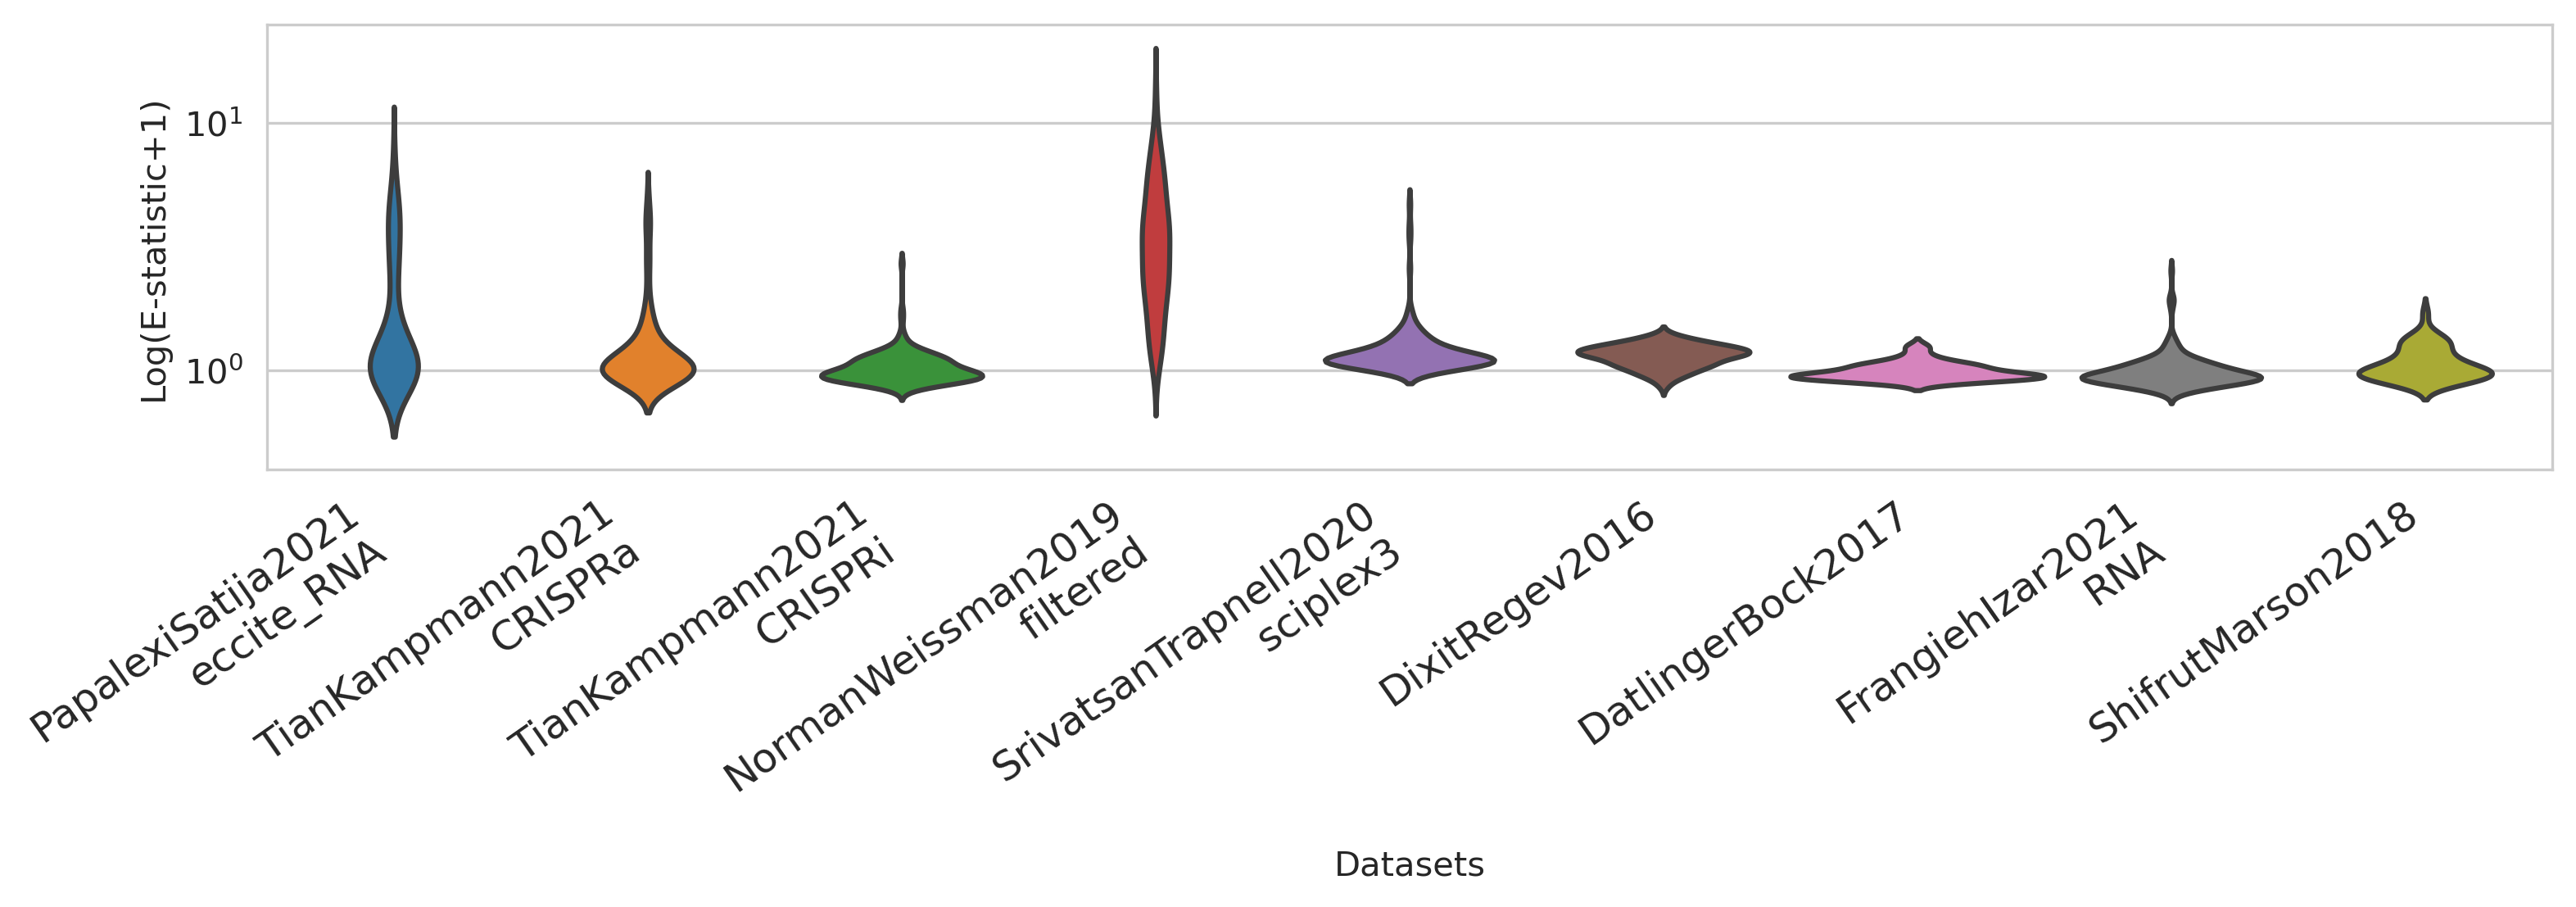

In [1087]:
scale = 0.6
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 4*scale], dpi=300)
pairs_all['tmp'] = np.log10(pairs_all[0]+1)
sns.violinplot(data=pairs_all[pairs_all['E-statistic']=='perturbed-unperturbed'], x='dataset_pretty', y='tmp', width=1, inner=None)
pl.xticks(rotation=35, ha='right', fontsize=12)
pl.ylabel('Log(E-statistic+1)')
pl.xlabel('Datasets')
# pl.xlim([-1.5,5])

# log scale y ticks
from matplotlib import ticker as mticker
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(0, 2)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_ylim([-0.4, 1.4])

pl.savefig('../../figures/violin_estatistics_horizontal.pdf', bbox_inches='tight')
pl.show()

# Estat selected dataset (NormanWeissman)

In [799]:
key = 'NormanWeissman2019_filtered'
pairs = pairs_datasets[key]
estats = estats_datasets[key]
estats_control = pd.DataFrame(estats.loc[:, 'control'])
estats_control.columns=['E-statistic']

In [904]:
indices = list(estats_control['E-statistic'].sort_values().index)
N = 3
top=indices[-N:]
bot=indices[:N]
strong = list(estats_control.index[estats_control['E-statistic']>2]) + ['control']

## similarity heatmap

### all

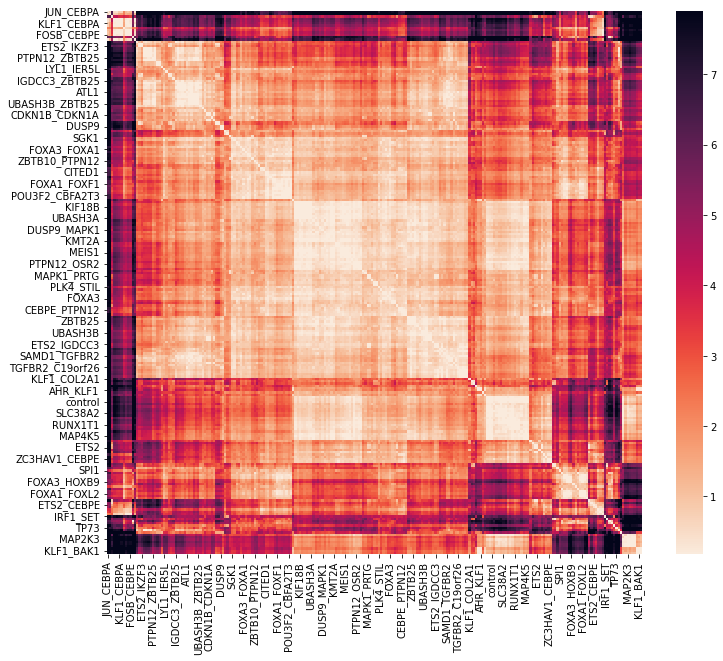

In [597]:
pl.figure(figsize=[12,10])
sns.heatmap(estats, robust=True, cmap='rocket_r')
pl.savefig('../../figures/estat_heatmap_all.pdf', bbox_inches='tight')
pl.show()

### clustering

In [770]:
from scipy.cluster.hierarchy import distance, linkage, dendrogram, cut_tree
method = 'centroid'
M = estats
dist = distance.pdist(M)
link = linkage(dist, method=method)
dend = dendrogram(link, no_plot=True)
order = np.array(dend['leaves'], dtype=int)

In [772]:
labels = np.array(np.squeeze(cut_tree(link, n_clusters=10, height=None)))

In [773]:
# ctrl_label = labels[np.where(estats.index=='control')[0][0]]
# ctrl_buddies = np.random.choice(estats.index[labels==ctrl_label], 5)
# sub = (labels!=ctrl_label) | (estats.index=='control') | np.isin(estats.index, ctrl_buddies)
sub = np.isin(estats.index, strong)

In [784]:
df_labels = pd.DataFrame(labels, index=estats.index, columns=['label'])

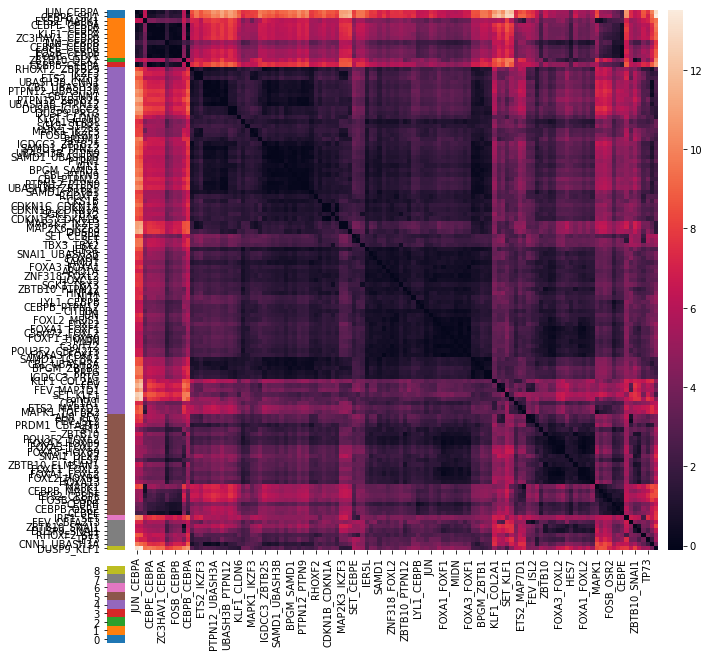

In [776]:
heatmap_with_cats(estats.iloc[sub,sub], row_labels=labels[sub], figsize=[10, 11], col_rot=90, width_ratios=(0.25, 7, 0.2), row_cmap='tab10', show=False)  # dpi=120, 
# pl.savefig('../../figures/estat_heatmap_clustered.pdf', bbox_inches='tight')
pl.show()

### tops/bots

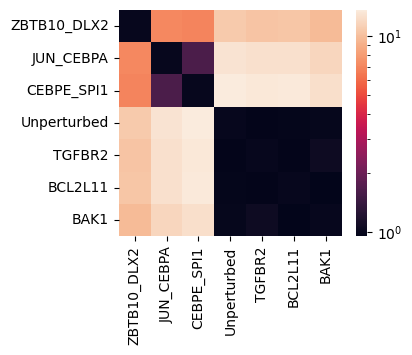

In [1050]:
# scale=0.3
# pl.subplots(figsize=[12*scale,10*scale], dpi=100)
# from matplotlib.colors import LogNorm
# conds = top + ['control'] + bot
# sub = estats.loc[conds, conds] + 1
# sub = sub.rename({'control': 'Unperturbed'}, axis=1).rename({'control': 'Unperturbed'}, axis=0)
# sns.heatmap(sub, robust=False, norm=LogNorm())
# # pl.xticks(rotation=45, ha='right', va='top')
# pl.savefig('../../figures/estat_simil_small_log.pdf', bbox_inches='tight')
# pl.show()

# conds = top + ['control'] + bot
# sub = np.log(estats.loc[conds, conds] + 1)
# sns.heatmap(sub, robust=False)
# pl.show()

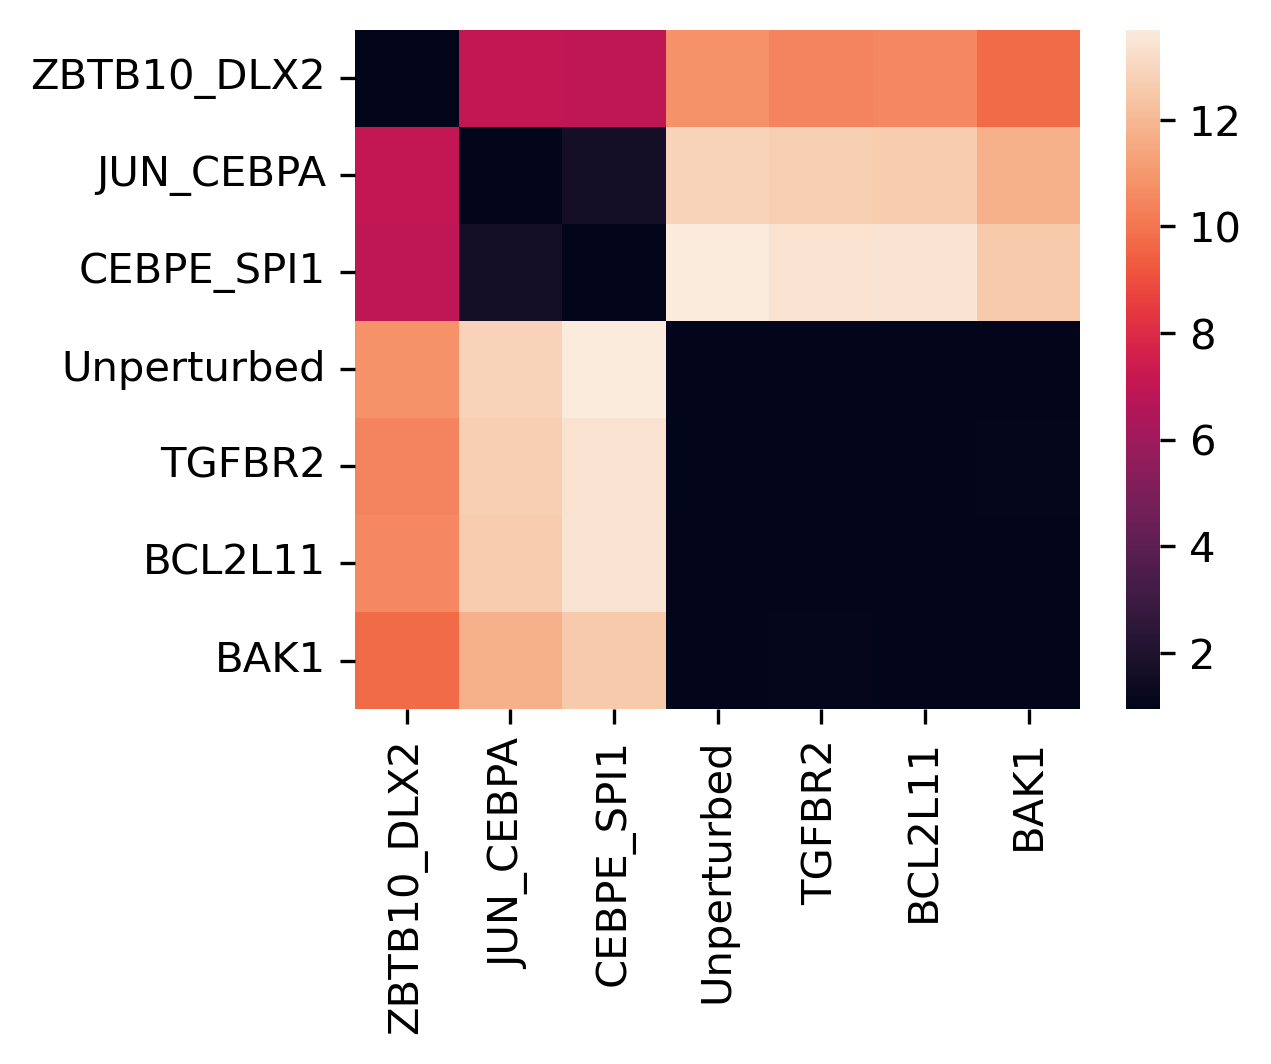

In [1091]:
scale=0.3
pl.subplots(figsize=[13*scale,10*scale], dpi=300)
conds = top + ['control'] + bot
sub = estats.loc[conds, conds] + 1
sub = sub.rename({'control': 'Unperturbed'}, axis=1).rename({'control': 'Unperturbed'}, axis=0)
sns.heatmap(sub, robust=False)
# pl.xticks(rotation=45, ha='right', va='top')
pl.savefig('../../figures/estat_simil_small.pdf', bbox_inches='tight')
pl.show()

### entropy

In [382]:
from scipy.stats import entropy

In [477]:
T = np.clip(estats,0, np.infty)
ent = entropy(T, axis=0)
Z = zscore(ent)

In [478]:
estats_control['entropy_score'] = Z

In [479]:
estats_control

E-statistic  entropy_score group       tmp
JUN_CEBPA         11.879510       1.594626   top  2.555638
CEBPE_SPI1        12.691019       1.602094   top  2.616740
ETS2_MAPK1         5.768262       1.672843   mid  1.912244
CEBPE_CEBPA        7.952438       1.455109   top  2.191926
CEBPA              7.657737       1.472343   top  2.158453
...                     ...            ...   ...       ...
MAP2K3_MAP2K6      0.932778       0.269109   mid  0.658958
MAP2K6_ELMSAN1     1.047701       0.350686   mid  0.716718
KLF1               1.658077       0.678871   mid  0.977603
KLF1_BAK1          1.262315       0.394110   mid  0.816389
KLF1_MAP2K6        1.438678       0.490418   mid  0.891456

[237 rows x 4 columns]

## detailed violin

In [1016]:
estats_control['group'] = 'mid'
estats_control['group'][np.isin(estats_control.index, top)] = 'top'
estats_control['group'][np.isin(estats_control.index, bot)] = 'bot'
estats_control['group'][np.isin(estats_control.index, ['control'])] = 'control'

In [1072]:
# add e-test results
tab = pd.read_csv(f'{table_path}etest_{key}_tables.csv', index_col=0)
if 'pvalue' not in estats_control.columns:
    estats_control = pd.merge(estats_control, tab, left_index=True, right_index=True, how='left')

In [1078]:
estats_control

E-statistic       tmp group       edist  pvalue  significant  \
JUN_CEBPA         11.879510  1.109899   top  366.551648     0.0         True   
CEBPE_SPI1        12.691019  1.136436   top  382.753653     0.0         True   
ETS2_MAPK1         5.768262  0.830477   mid  131.522315     0.0         True   
CEBPE_CEBPA        7.952438  0.951941   mid  242.746348     0.0         True   
CEBPA              7.657737  0.937404   mid  238.981450     0.0         True   
...                     ...       ...   ...         ...     ...          ...   
MAP2K3_MAP2K6      0.932778  0.286182   mid   14.635719     0.0         True   
MAP2K6_ELMSAN1     1.047701  0.311266   mid   17.020981     0.0         True   
KLF1               1.658077  0.424568   mid   28.535733     0.0         True   
KLF1_BAK1          1.262315  0.354553   mid   22.372086     0.0         True   
KLF1_MAP2K6        1.438678  0.387154   mid   25.252537     0.0         True   

                pvalue_adj  significant_adj  
JUN_CEBPA              0.0             True  
CEBPE_SPI1             0.0             True  
ETS2_MAPK1             0.0             True  
CEBPE_CEBPA            0.0             True  
CEBPA                  0.0             True  
...                    ...              ...  
MAP2K3_MAP2K6          0.0             True  
MAP2K6_ELMSAN1         0.0             True  
KLF1                   0.0             True  
KLF1_BAK1              0.0             True  
KLF1_MAP2K6            0.0             True  

[237 rows x 8 columns]

In [1013]:
# scale=0.75
# with sns.axes_style('whitegrid'):
#     fig, ax = pl.subplots(figsize=[16*scale, 5*scale], dpi=120)  # [8*scale, 5*scale]
# width = 0.8
# estats_control['tmp'] = np.log(estats_control['E-statistic']+1)
# sns.violinplot(data=estats_control, x='tmp', inner=None, color=".8", width=width)
# # sns.histplot(data=estats_control, x='E-statistic', bins=50)
# palette = {
#     'top' : 'tab:red',
#     'bot' : 'tab:blue',
#     'mid' : 'tab:grey',
#     'control': 'tab:orange'
# }

# s = 70
# # sns.scatterplot(data=estats_control, x='tmp', y=np.random.uniform(-width/3,width/3, len(estats_control)), hue='tmp', s=50, palette='viridis')
# y = np.random.uniform(-width/2.5,width/2.5, len(estats_control))
# ax.scatter(estats_control.tmp, y, c=estats_control.tmp, marker="D", edgecolors='white', s=s)
# idx = np.where(estats_control.index=='control')[0][0]
# ax.scatter(estats_control.tmp[idx], y[idx], c='orange', marker="D", edgecolors='black', s=s*2, linewidth=2)
# # pl.title('Perturbations with high/low E-distance\nfrom unperturbed')
# pl.xlabel('Log(E-distance+1)')
# pl.ylim([-.5,.5])
# # pl.savefig('../../figures/estat_detailed_violin.pdf', bbox_inches='tight')
# pl.show()

In [1099]:
estats_control['significant_adj_'] =  estats_control['significant_adj']
estats_control.loc['control', 'significant_adj_'] = 'Unperturbed'

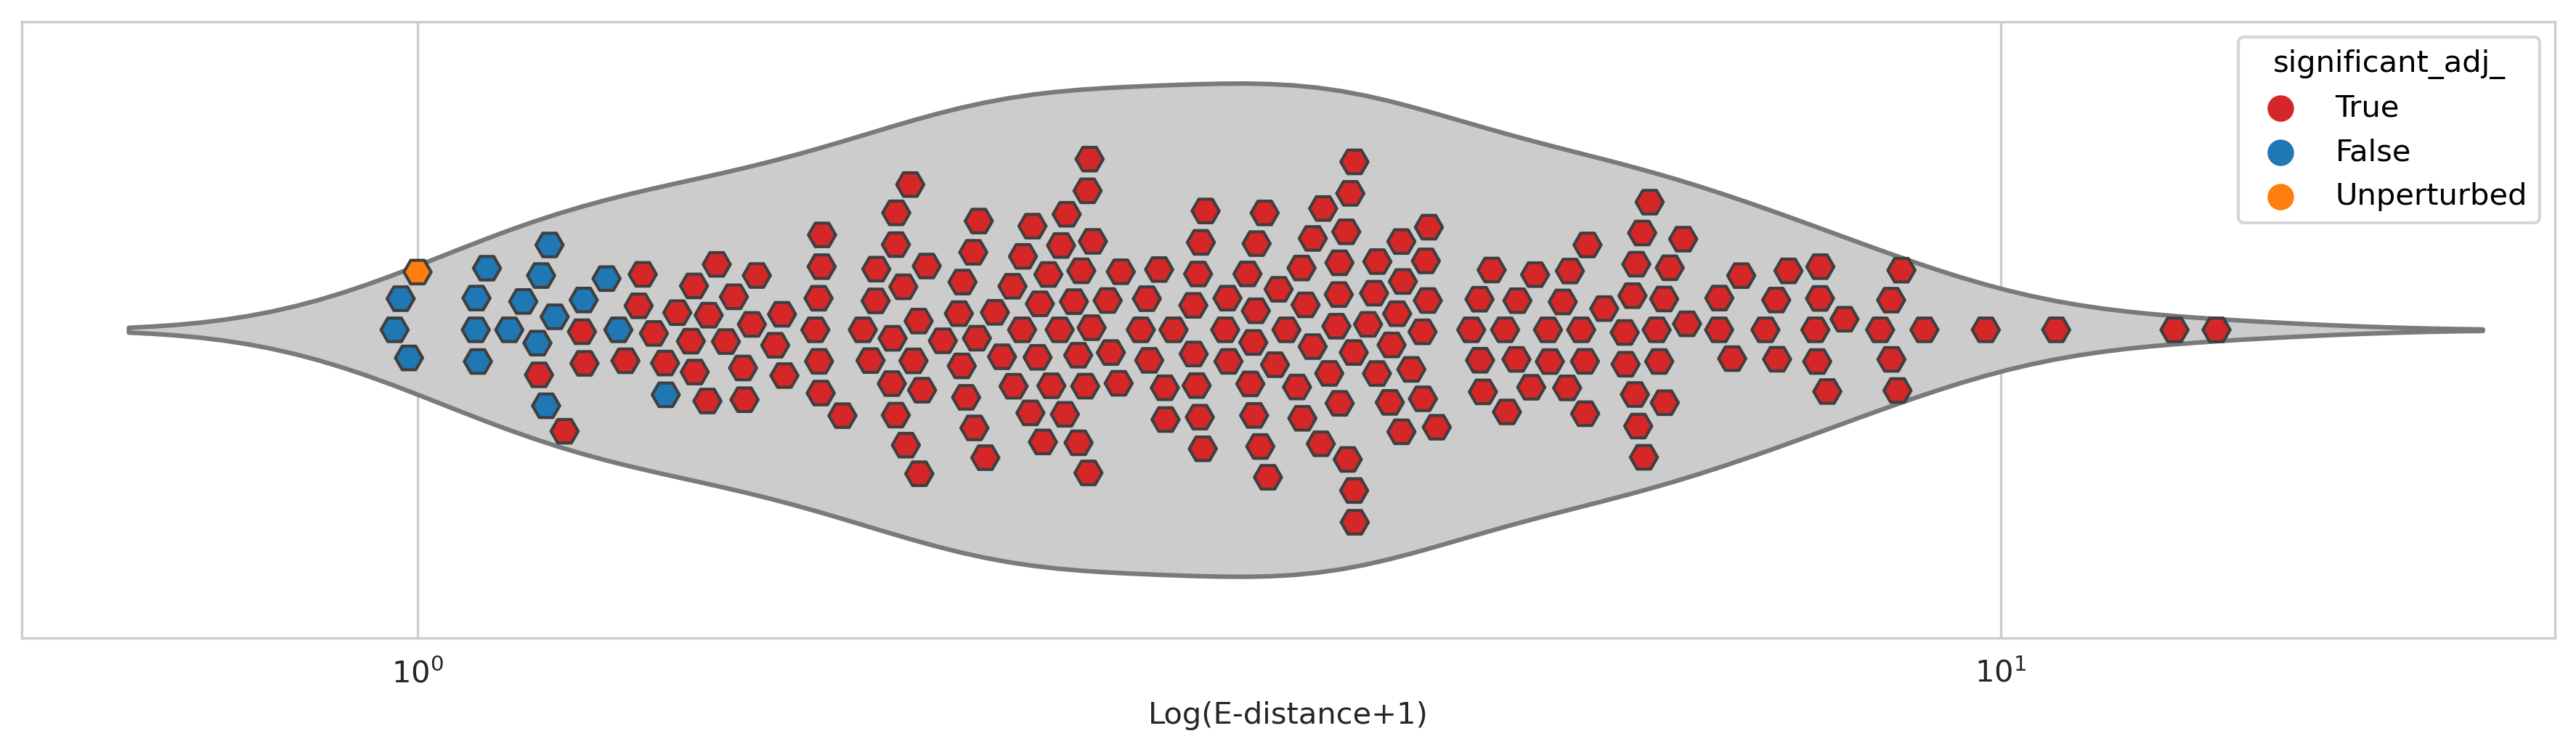

In [1105]:
scale=0.75
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 5*scale], dpi=300)  # [8*scale, 5*scale]
estats_control['tmp'] = np.log10(estats_control['E-statistic']+1)
sns.violinplot(data=estats_control, x='tmp', inner=None, color=".8", width=0.8)
ax = sns.swarmplot(data=estats_control, x=estats_control['tmp'], y=['']*len(estats_control), size=9, 
                   marker="H", edgecolors='white', linewidth=1, hue='significant_adj_', palette=['tab:red', 'tab:blue', 'tab:orange'])
pl.xlabel('Log(E-distance+1)')

# log scale x ticks
from matplotlib import ticker as mticker
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
xmin, xmax = ax.get_xlim()
tick_range = np.arange(0, xmax)
ax.xaxis.set_ticks(tick_range)
ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_xlim([-0.25, 1.35])
pl.savefig('../../figures/estat_detailed_violin_alt.pdf', bbox_inches='tight')
pl.show()

## embeddings

In [731]:
adata = sc.read(f'{SDIR}tmp_data_{key}.h5')

In [905]:
adata.obs['group'] = None
adata.obs['group'][np.isin(adata.obs.perturbation, top)] = 'top'
adata.obs['group'][np.isin(adata.obs.perturbation, bot)] = 'bot'
adata.obs['group'][np.isin(adata.obs.perturbation, ['control'])] = 'control'

In [906]:
if 'label' not in adata.obs.columns:
    adata.obs = pd.merge(adata.obs, df_labels, how='left', left_on='perturbation', right_index=True)

### single cell

In [1093]:
sdata = adata[np.isin(adata.obs.perturbation, top+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:grey', 'tab:red']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

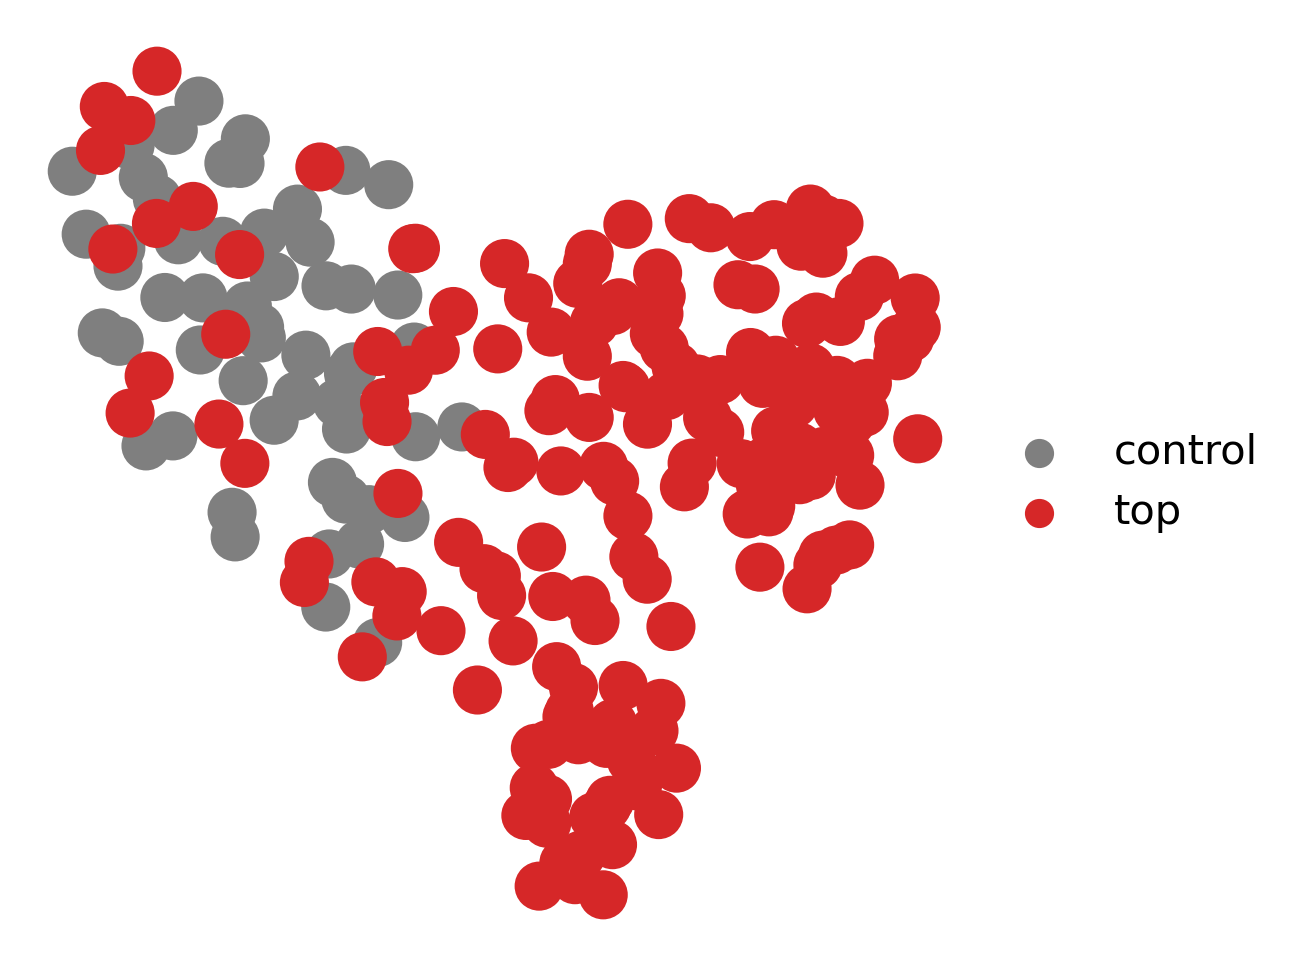

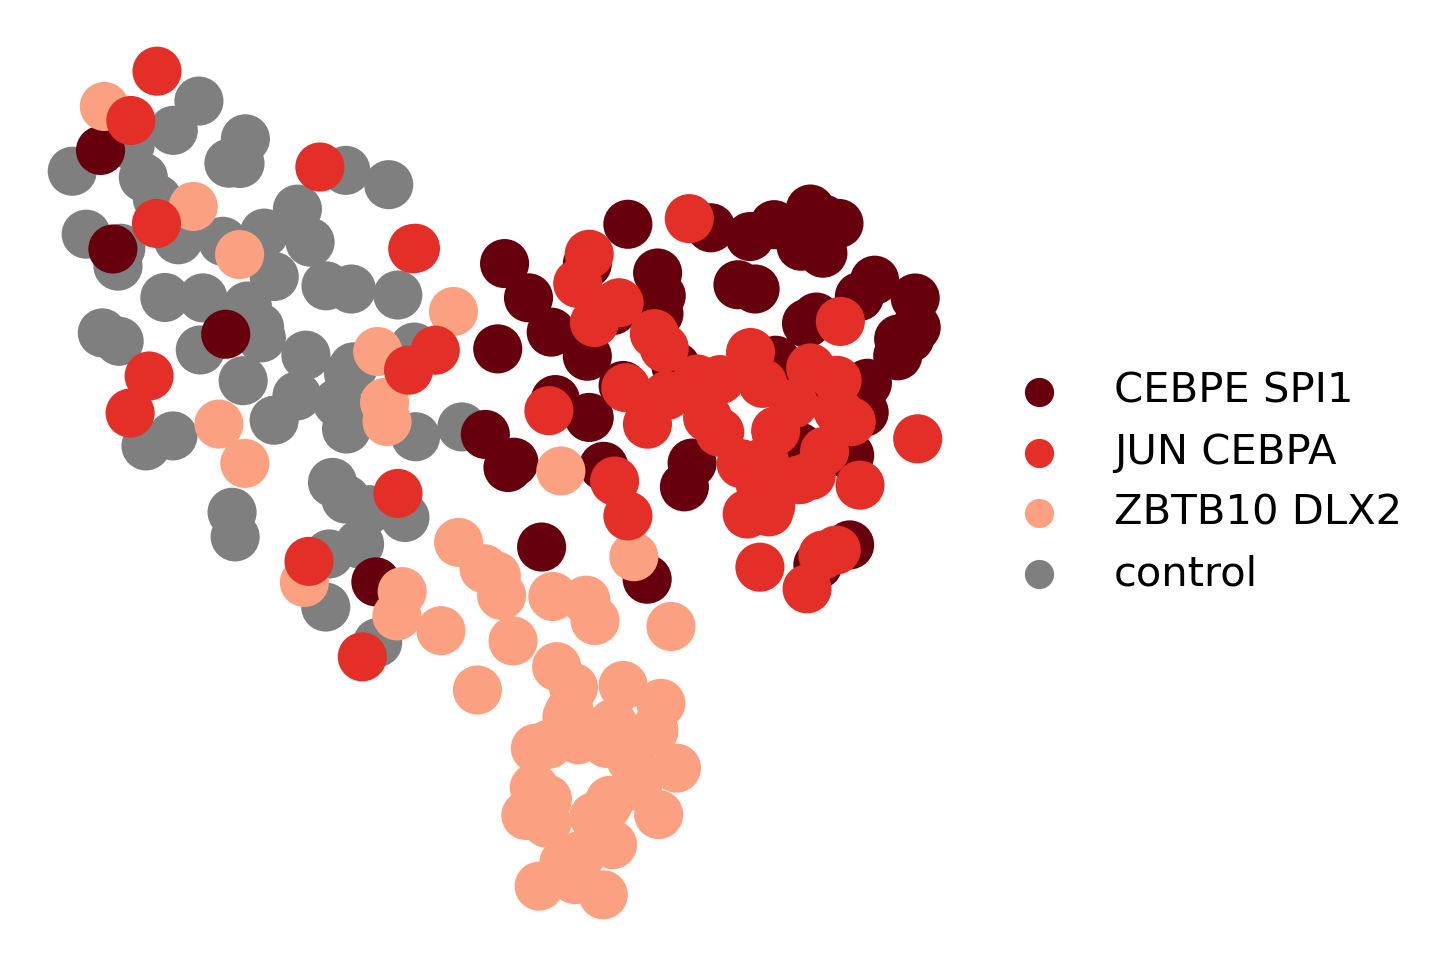

In [1094]:
scv.pl.scatter(sdata, color='group', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig('../../figures/sc_umap_top_summarized_clusters.pdf', bbox_inches='tight')
pl.show()
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig('../../figures/sc_umap_top_clusters.pdf', bbox_inches='tight')
pl.show()

In [1095]:
sdata = adata[np.isin(adata.obs.perturbation, bot+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:blue', 'tab:grey']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

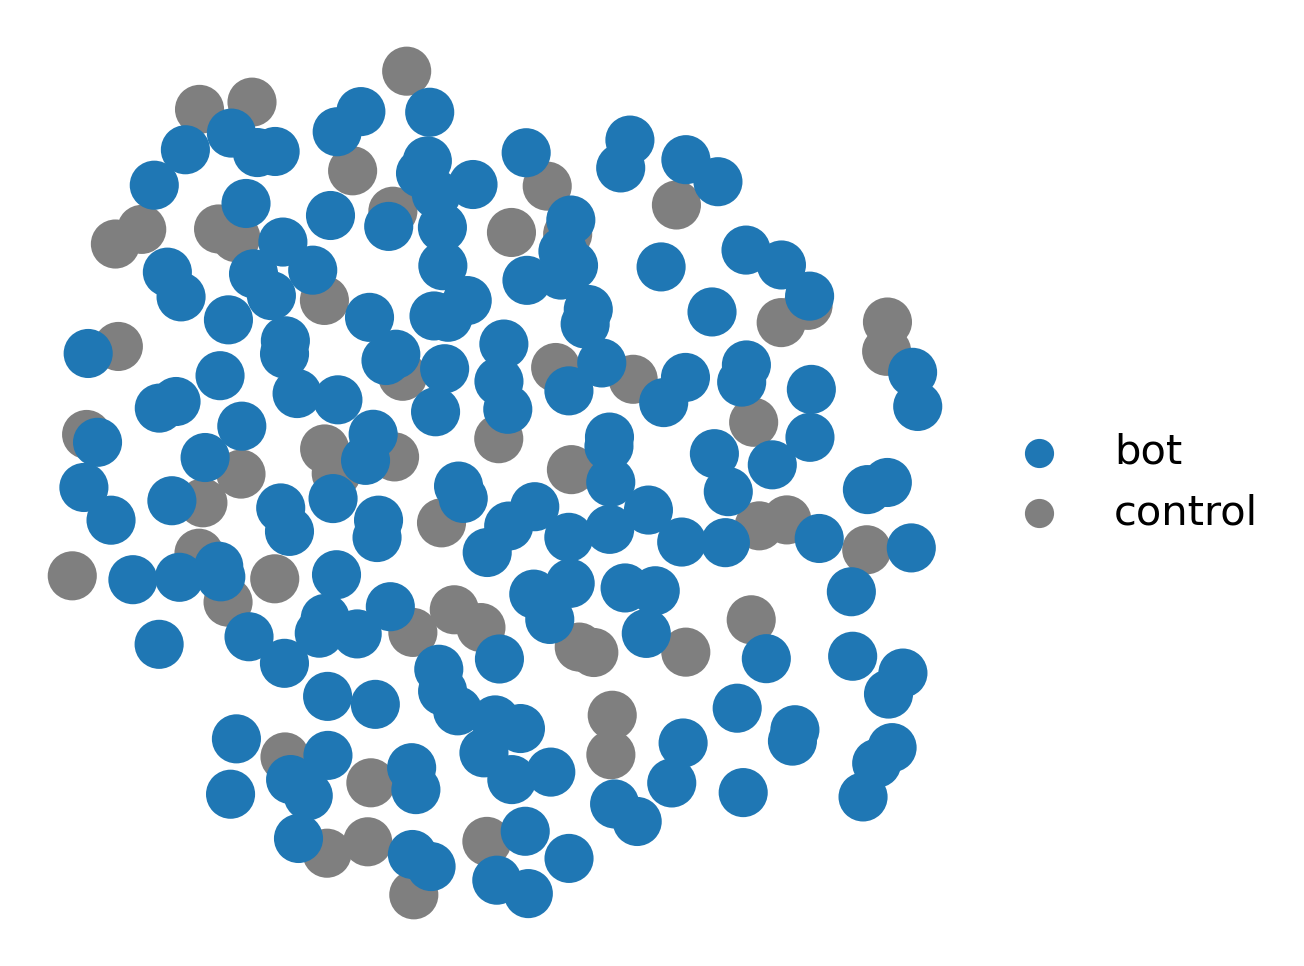

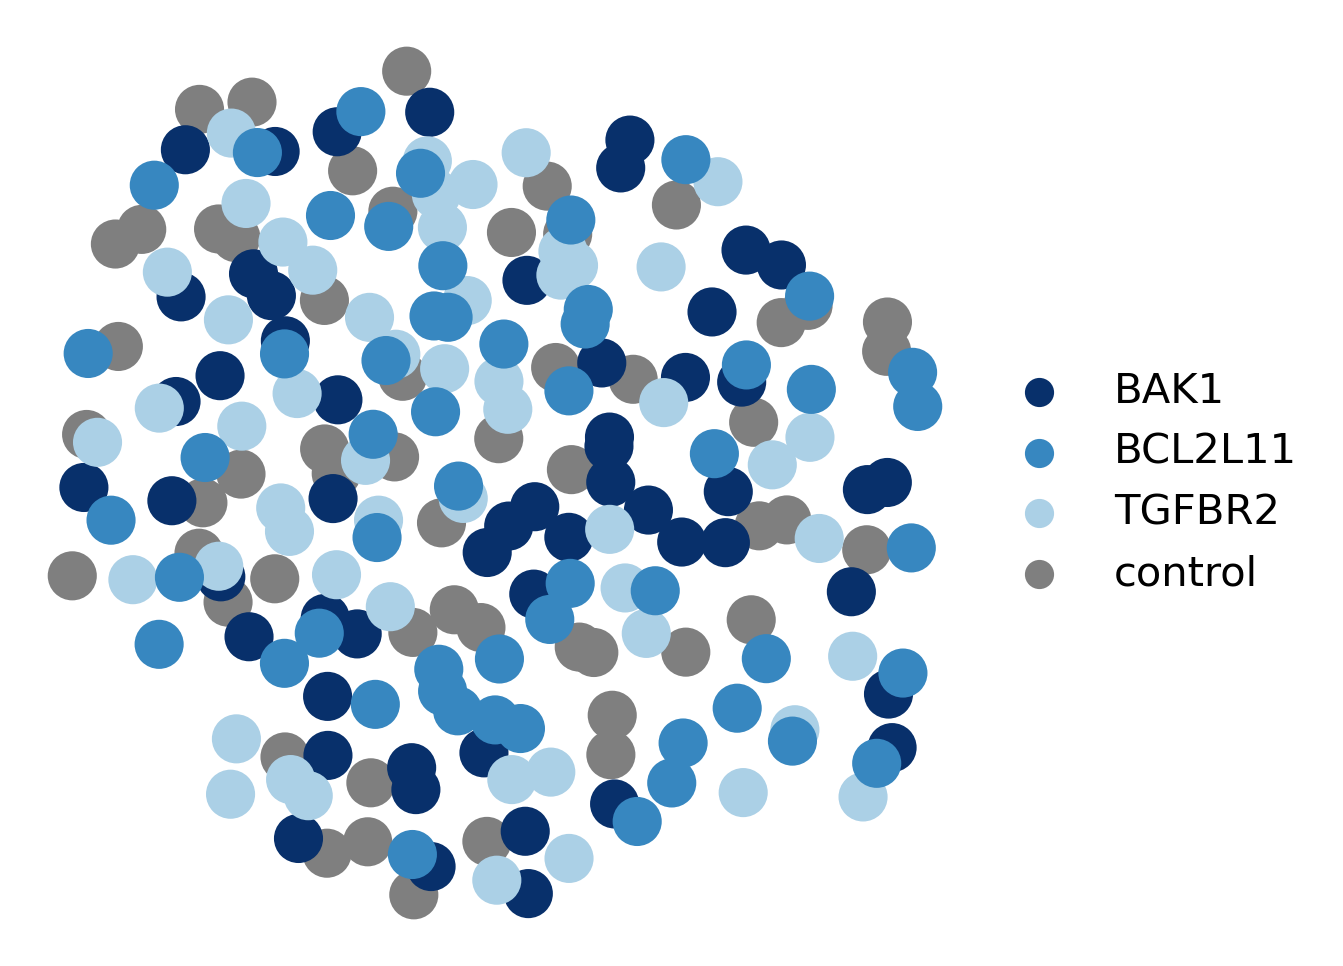

In [1096]:
scv.pl.scatter(sdata, color='group', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig('../../figures/sc_umap_bot_summarized_clusters.pdf', bbox_inches='tight')
pl.show()
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='')
pl.savefig('../../figures/sc_umap_bot_clusters.pdf', bbox_inches='tight')
pl.show()

In [1098]:
# scv.pl.scatter(sdata, color='label', legend_loc='right margin', figsize=[6,6], show=False, dpi=120, hspace=0)
# pl.show()

In [768]:
# tdata = adata[np.isin(adata.obs.perturbation, strong)].copy()
# sc.pp.pca(tdata, use_highly_variable=False)
# sc.pp.neighbors(tdata)
# sc.tl.umap(tdata)

In [1097]:
# scv.pl.scatter(tdata, color='label', legend_loc='right margin', figsize=[6,6], show=False, dpi=120, title='')
# pl.savefig('../../figures/sc_umap_clusters.pdf', bbox_inches='tight')
# pl.show()

### pseudobulk

In [786]:
def pseudo_bulk(adata, keys, layer='counts', min_cells_per_group=10):
    X = []
    Y = []
    for gs in product(*[pd.unique(adata.obs[key]) for key in keys]):
        mask = np.logical_and.reduce([adata.obs[key]==g for g, key in zip(gs, keys)])
        if sum(mask) < min_cells_per_group: continue
        Y.append(gs)
        X_ = adata[mask].layers[layer] if layer!=None else adata[mask].X
        X.append(np.array(np.sum(X_, axis=0), dtype=int)[0])
    return sc.AnnData(np.array(X), obs=pd.DataFrame(Y, columns=keys), var=adata.var)

In [787]:
pdata = pseudo_bulk(adata, ['perturbation'], layer=None)
pdata = pdata[np.isin(pdata.obs.perturbation, strong)].copy()  # select strongly different only

In [824]:
sc.pp.pca(pdata, use_highly_variable=False)
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)

In [789]:
pdata.obs['group'] = None
pdata.obs['group'][np.isin(pdata.obs.perturbation, top)] = 'top'
pdata.obs['group'][np.isin(pdata.obs.perturbation, bot)] = 'bot'
pdata.obs['group'][np.isin(pdata.obs.perturbation, ['control'])] = 'control'
pdata.uns['group_colors'] = ['tab:blue', 'tab:grey', 'tab:red']

In [790]:
if 'E-statistic' not in pdata.obs.columns:
    pdata.obs = pd.merge(pdata.obs, estats_control, left_on='perturbation', right_index=True, how='left')
if 'group' not in pdata.obs.columns:
    pdata.obs['group'] = pdata.obs['group_x']

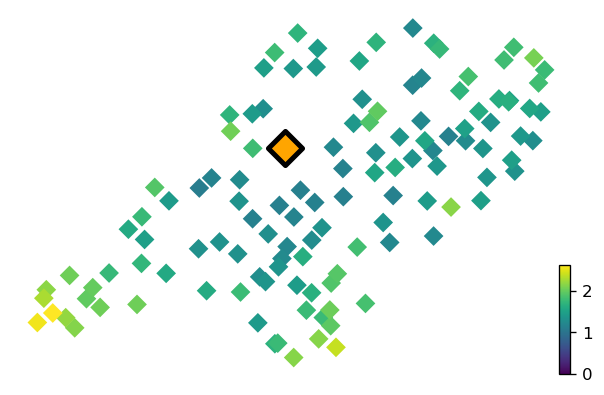

In [839]:
from scvelo.plotting.scatter import default_size
s=70#default_size(pdata)
pdata.obs['logE-statistic'] = np.log(pdata.obs['E-statistic']+1)
ax=scv.pl.scatter(pdata, color=['logE-statistic'], legend_loc='right margin', dpi=120,
                  s=s, show=False, marker='D')
ax=scv.pl.scatter(pdata[pdata.obs['group']=='control'], color='orange', legend_loc='right margin', ax=ax, s=s*3, edgecolor='black', linewidths=3, show=False, marker='D')
# ax.set_title('Pseudobulk UMAP\ncolored by E(Perturbation, Unperturbed)')
# pl.savefig('../../figures/pb_umap_estat.pdf', bbox_inches='tight')
pl.show()

In [792]:
if 'label' not in pdata.obs.columns:
    pdata.obs = pd.merge(pdata.obs, df_labels, how='left', left_on='perturbation', right_index=True)

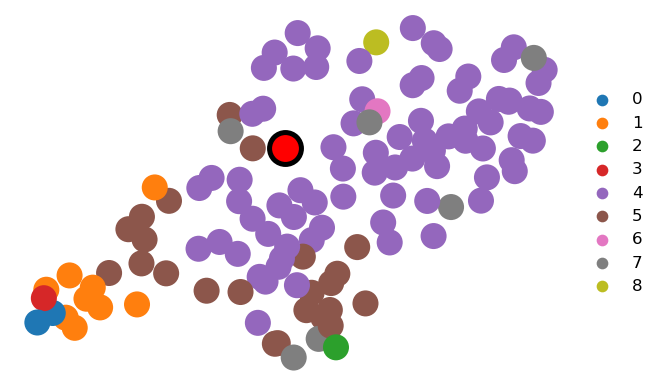

In [793]:
from scvelo.plotting.scatter import default_size
s=default_size(pdata)
ax=scv.pl.scatter(pdata, color=['label'], legend_loc='right margin', dpi=120,
                  perc=[5,95], s=s, show=False)
ax=scv.pl.scatter(pdata[pdata.obs.group=='control'], color='red', legend_loc='right margin', ax=ax, s=s*1.5, edgecolor='black', linewidths=3, show=False)
# ax.set_title('Pseudobulk UMAP\ncolored by E(Perturbation, Unperturbed)')
pl.show()

In [796]:
# compute embedding from e-distances!
# https://github.com/cvxgrp/pymde/issues/27#issuecomment-839399586

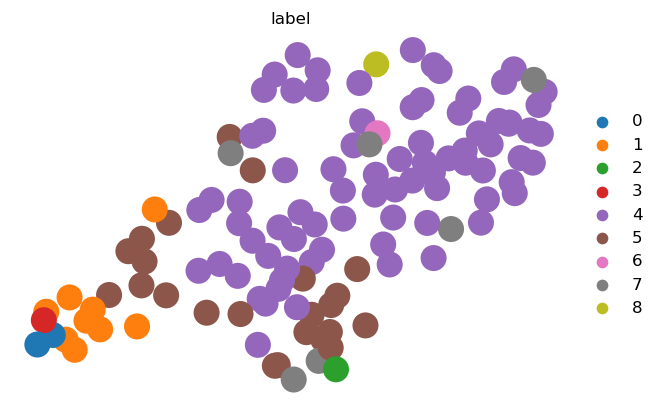

In [797]:
scv.pl.scatter(pdata, color=['label'], legend_loc='right margin', dpi=120,
                  perc=[5,95], s=s, show=True)

In [876]:
sub_estats = estats.loc[pdata.obs.perturbation, pdata.obs.perturbation]

from scipy.sparse import csr_matrix
X = csr_matrix(sub_estats.values)

import pymde
mde = pymde.preserve_distances(X)
embedding = mde.embed()
pdata.obsm['X_mde'] = np.array(embedding)

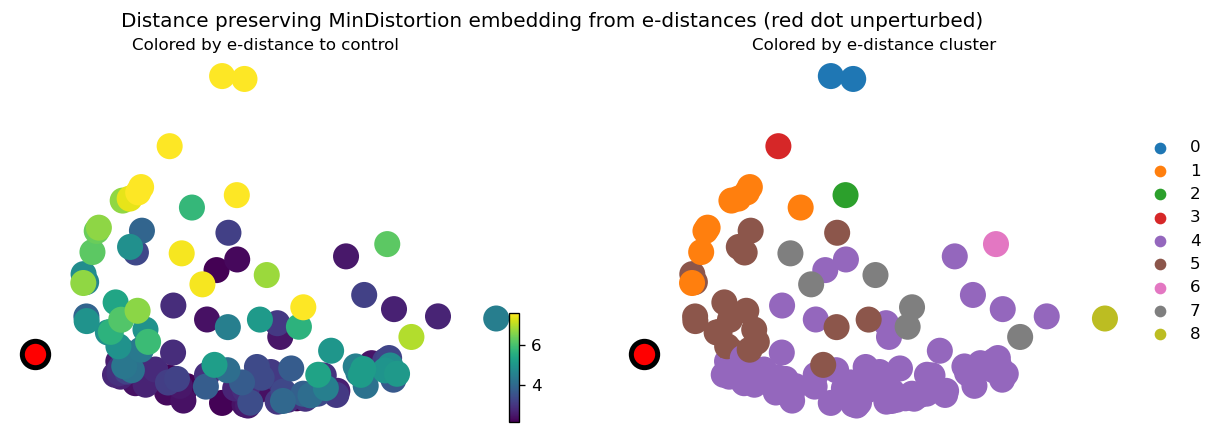

In [877]:
axs=scv.pl.scatter(pdata, color=['E-statistic', 'label'], legend_loc='right margin', dpi=120,
                  perc=[5,95], show=False, basis='mde')
for ax, name in zip(axs, ['Colored by e-distance to control', 'Colored by e-distance cluster']):
    scv.pl.scatter(pdata[pdata.obs.group=='control'], color='red', legend_loc='right margin', 
                   ax=ax, s=1000, edgecolor='black', linewidths=3, show=False, basis='mde',
                   title=name
                  )
# ax.set_title('Pseudobulk UMAP\ncolored by E(Perturbation, Unperturbed)')
pl.suptitle('Distance preserving MinDistortion embedding from e-distances (red dot unperturbed)')
pl.show()

In [882]:
import umap
my_model = umap.UMAP(metric='precomputed')#, n_neighbors=10, min_dist=0.1, spread=1.0)
my_model_fit = my_model.fit_transform(X)
pdata.obsm['X_custom_umap'] = my_model_fit

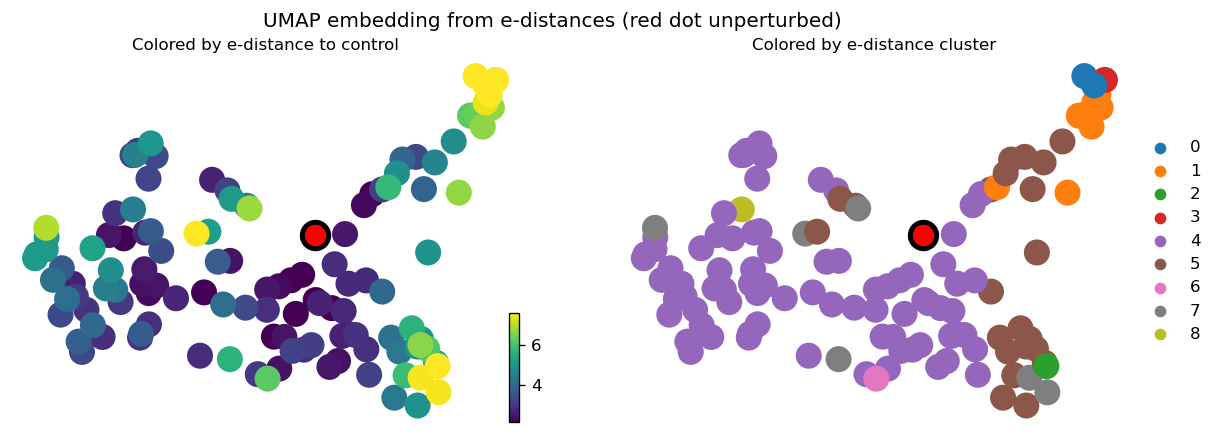

In [883]:
axs=scv.pl.scatter(pdata, color=['E-statistic', 'label'], legend_loc='right margin', dpi=120,
                  perc=[5,95], show=False, basis='custom_umap')
for ax, name in zip(axs, ['Colored by e-distance to control', 'Colored by e-distance cluster']):
    scv.pl.scatter(pdata[pdata.obs.group=='control'], color='red', legend_loc='right margin', 
                   ax=ax, s=1000, edgecolor='black', linewidths=3, show=False, basis='custom_umap',
                   title=name
                  )
# ax.set_title('Pseudobulk UMAP\ncolored by E(Perturbation, Unperturbed)')
pl.suptitle('UMAP embedding from e-distances (red dot unperturbed)')
pl.show()

# Old

## Sigma vs Sigma

In [159]:
#looks really cool for 
cool_ones = ['PapalexiSatija2021_eccite_RNA', 'TianKampmann2021_CRISPRa', 'TianKampmann2021_CRISPRi', 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen', 'SrivatsanTrapnell2020_sciplex3', 'DixitRegev2016', 'DatlingerBock2017', 'FrangiehIzar2021_RNA', 'ShifrutMarson2018']

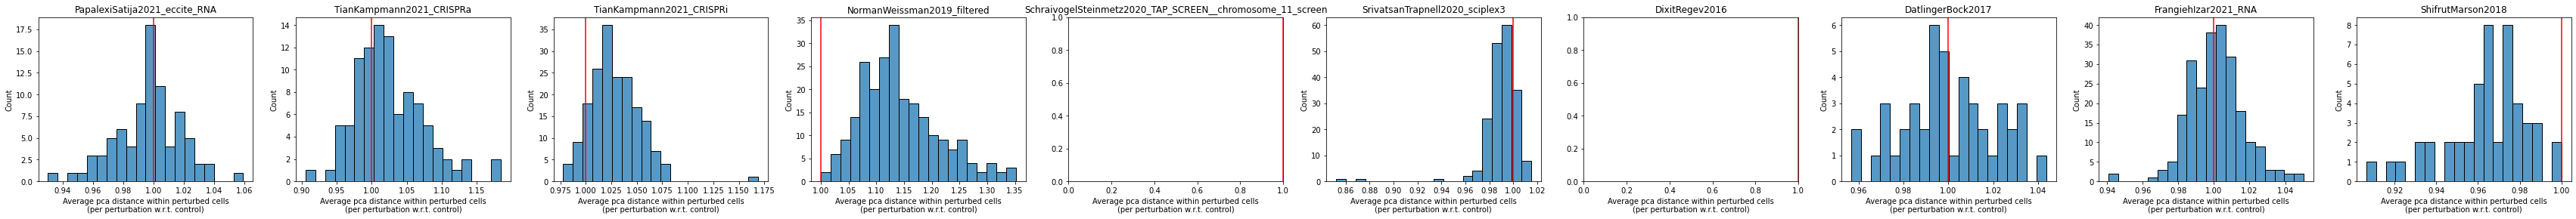

In [161]:
# sigma vs sigma
# did sigma increase in any perturbations?
D = len(cool_ones)
fig, axs = pl.subplots(1, D, figsize=[6*D,4])
for ax, key in zip(axs, cool_ones):
    x = tab['stdpstd'][tab.dataset==key]
    sns.histplot(x, bins=20, ax=ax)
    ax.axvline(1, color='red')
    ax.set_xlabel('Average pca distance within perturbed cells\n(per perturbation w.r.t. control)')
    ax.set_title(key)
pl.show()

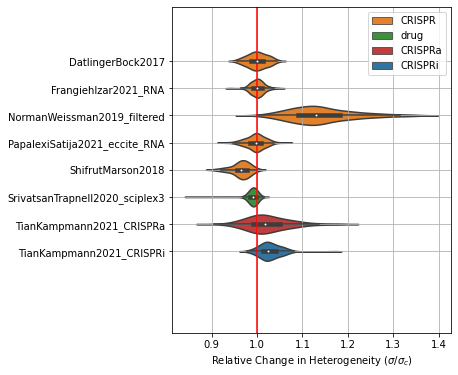

In [163]:
pl.figure(figsize=[5,6])
sns.violinplot(data=tab, y='dataset', x='stdpstd', width=0.7, hue='perturbation_type', dodge=False, palette=colors_perturbation_types)
pl.ylim(len(cool_ones), -2)
pl.legend()
pl.axvline(1, color='red')
pl.grid()
pl.ylabel('')
pl.xlabel(r'Relative Change in Heterogeneity ($\sigma/\sigma_c$)')
# pl.title('Gene Expression Heterogeneity ($\sigma$)'+'\nafter Perturbation w.r.t. Unperturbed '+r'($\sigma_c$)')
pl.savefig('../../figures/sigma_vs_sigma.pdf', bbox_inches='tight')
pl.show()

## Delta (vs Delta)

In [283]:
# delta expresses the variation between two distributions (usually perturbation). Ideas:
# mean pairwise distances between distributions
# Wasserstein distance (OT)

In [284]:
# essentially it is the diagonal of the sigma matrices
# No it's not!

In [289]:
dpss = {}
for key in cool_ones:
    tab = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    tab = 1/tab  # redo inversion to get distances

    # this is the average sigma (sigma expresses the variation within one distribution)
    sigma = tab.loc['control', 'control']  #  * np.diag(tab)
    # this is the average delta (delta expresses the variation between two distributions)
    deltas = tab.loc['control', :]
    # delta per sigma
    dps = deltas / sigma
    dpss[key] = dps

In [290]:
# aggregate
df_ = pd.concat({key: pd.DataFrame(item) for key, item in dpss.items()}).reset_index(level=0)
df_ = df_.reset_index()
df_.columns = ['perturbation', 'dataset', 'dps']
df_ = df_.sort_values('dataset')  # I'm surprised this works
assert all(df_.perturbation.values == df.perturbation.values)
df_.head()
# add dps to sps
df['dps'] = df_['dps']

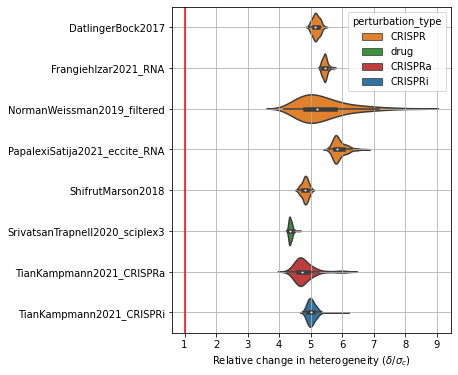

In [166]:
pl.figure(figsize=[5,6])
sns.violinplot(data=tab, y='dataset', x='dps', width=0.7, hue='perturbation_type', dodge=False, palette=colors_perturbation_types)
pl.axvline(1, color='red')
# pl.ylim(len(cool_ones)-1, -2)
# pl.xlim(0.7, 1.95)
pl.grid()
pl.ylabel('')
pl.xlabel(r'Relative change in heterogeneity ($\delta/\sigma_c$)')
# pl.title('Shift in Gene Expression ($\delta$)'+'\nafter Perturbation w.r.t. Unperturbed '+r'($\sigma_c$)')
pl.savefig('../../figures/delta_per_sigma.pdf', bbox_inches='tight')
pl.show()

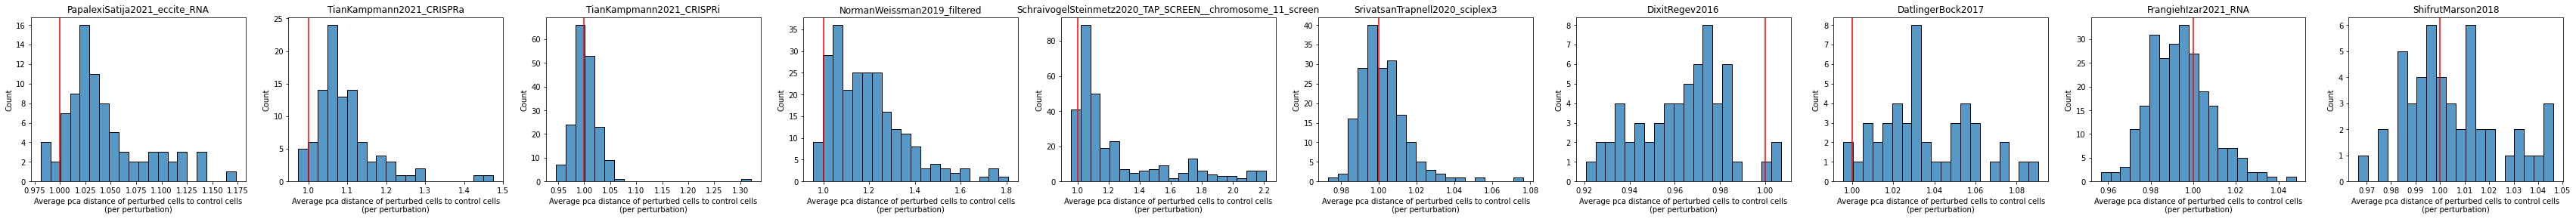

In [41]:
# sigma vs delta

D = len(cool_ones)
fig, axs = pl.subplots(1, D, figsize=[6*D,4])
for ax, key in zip(axs, cool_ones):
    dps = dpss[key]

    sns.histplot(dps, bins=20, ax=ax)
    ax.axvline(1, color='red')
    ax.set_xlabel('Average pca distance of perturbed cells to control cells\n(per perturbation)')
    ax.set_title(key)
pl.show()

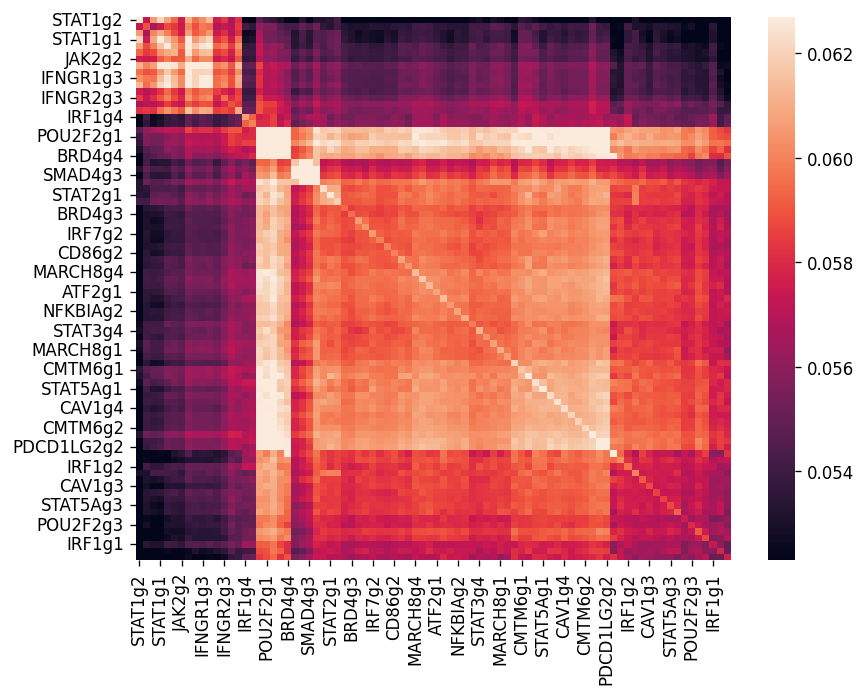

In [211]:
key = 'PapalexiSatija2021_eccite_RNA'
df = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
tab = cluster_matrix(df, 'both')
pl.figure(figsize=[8,6], dpi=120)
sns.heatmap(tab, robust=True)
pl.show()

## Comparing stats

In [61]:
tab.columns

Index(['sigma', 'std', 'delta', 'delta_mean', 'dataset', 'dps', 'sps',
       'stdpstd', 'dmps', 'estat', 'fraction', 'perturbation_type', 'organism',
       'tissue_type', 'cell_line', 'cancer', 'disease', 'celltype',
       'dataset_'],
      dtype='object')

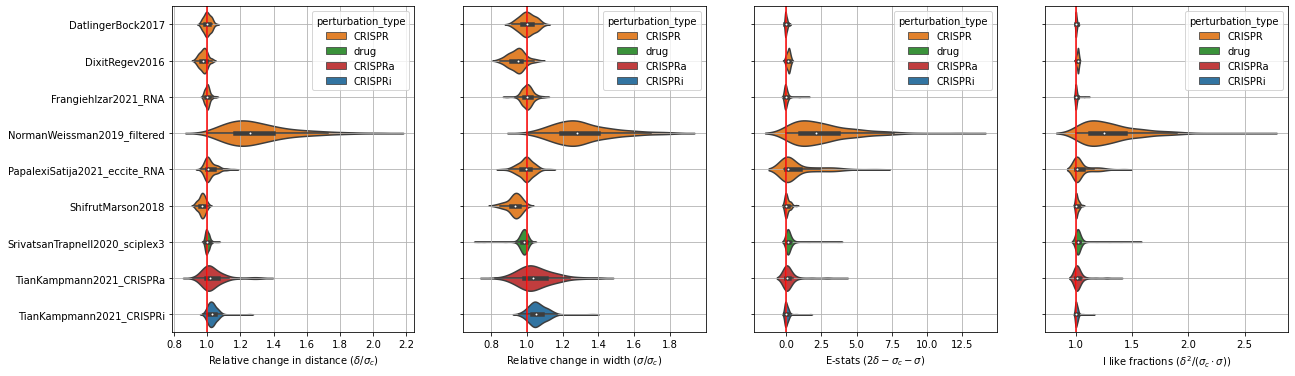

In [65]:
fig, axs = pl.subplots(1, 4, figsize=[5*4,6], sharey=True)
ax = axs[0]
sns.violinplot(data=tab, y='dataset', x='dps', width=0.7, hue='perturbation_type', 
               dodge=False, palette=colors_perturbation_types, ax=ax)
ax.axvline(1, color='red')
ax.grid()
ax.set_ylabel('')
ax.set_xlabel(r'Relative change in distance ($\delta/\sigma_c$)')

ax = axs[1]
sns.violinplot(data=tab, y='dataset', x='sps', width=0.7, hue='perturbation_type', 
               dodge=False, palette=colors_perturbation_types, ax=ax)
ax.axvline(1, color='red')
ax.grid()
ax.set_ylabel('')
ax.set_xlabel(r'Relative change in width ($\sigma/\sigma_c$)')

ax = axs[2]
sns.violinplot(data=tab, y='dataset', x='estat', width=0.7, hue='perturbation_type', 
               dodge=False, palette=colors_perturbation_types, ax=ax)
ax.axvline(0, color='red')
ax.grid()
ax.set_ylabel('')
ax.set_xlabel(r'E-stats ($2\delta-\sigma_c-\sigma$)')

ax = axs[3]
sns.violinplot(data=tab, y='dataset', x='fraction', width=0.7, hue='perturbation_type', 
               dodge=False, palette=colors_perturbation_types, ax=ax)
ax.axvline(1, color='red')
ax.grid()
ax.set_ylabel('')
ax.set_xlabel(r'I like fractions ($\delta^2/(\sigma_c\cdot\sigma)$)')

pl.show()

## Can we replace pw delta with mean delta?

- how does delta vs delta mean look like?
- how does sigma vs delta mean look like?

In [ ]:
# compute delta mean (pairwise pca distance between means)


## Delta vs Sigma (deprecated)

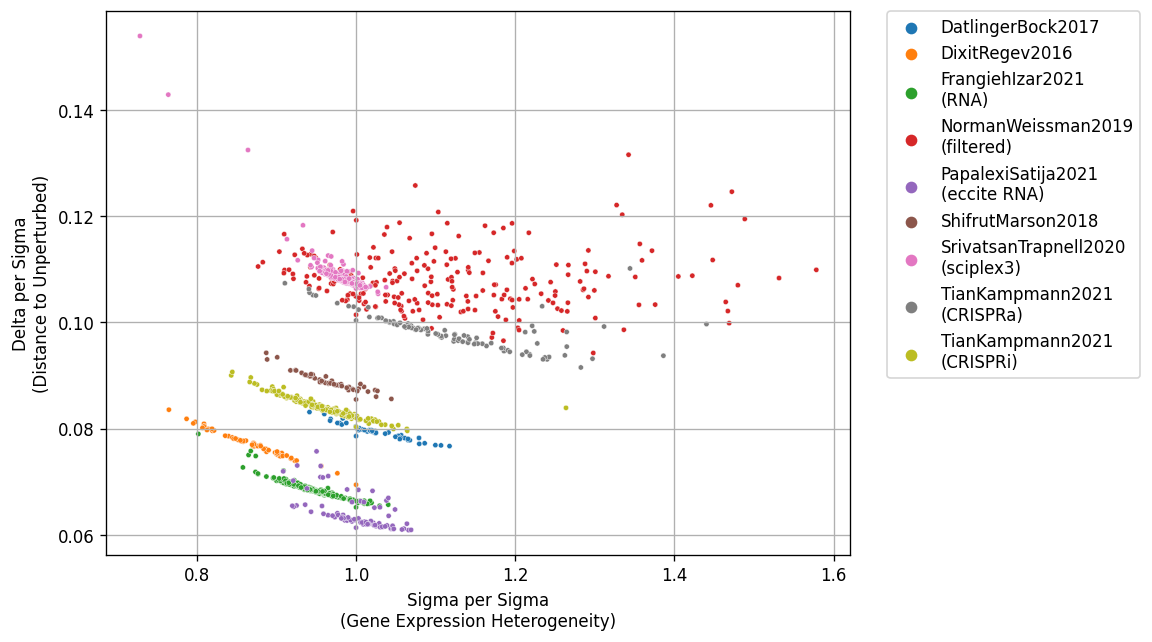

In [265]:
pl.figure(figsize=[8,6], dpi=120)
# sns.scatterplot(data=df, x='sps', y='dps', hue='dataset', s=10)
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10)
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
pl.grid()
pl.xlabel('Sigma per Sigma\n(Gene Expression Heterogeneity)')
pl.ylabel('Delta per Sigma\n(Distance to Unperturbed)')
# pl.title('Heterogeneity vs Distance\nw.r.t. Unperturbed for Selected Datasets')
pl.show()

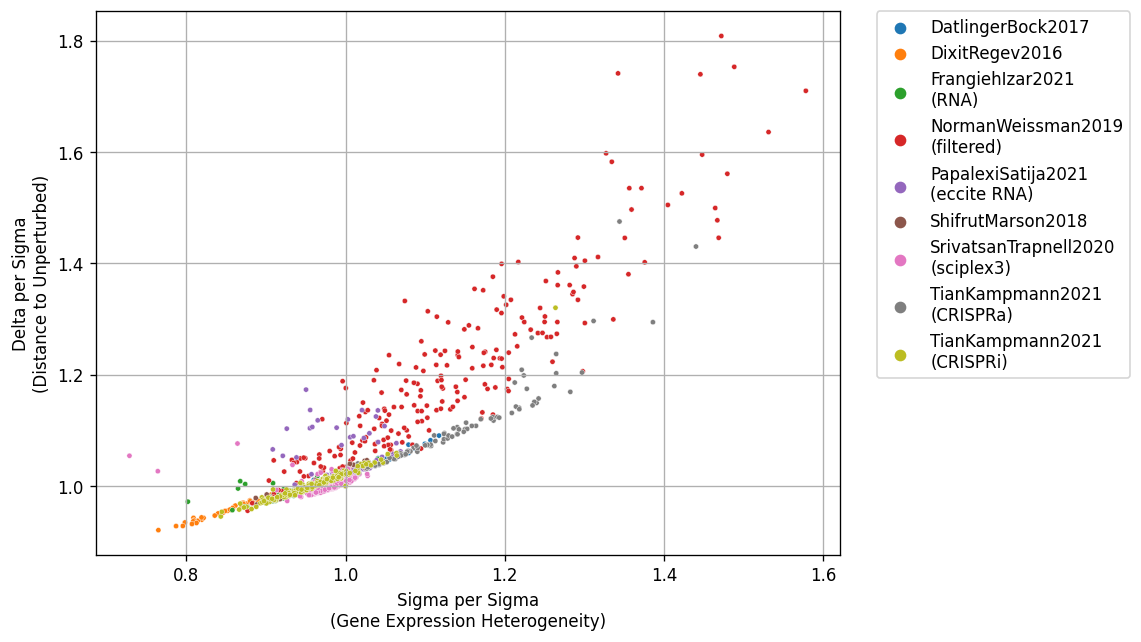

In [124]:
pl.figure(figsize=[8,6], dpi=120)
# sns.scatterplot(data=df, x='sps', y='dps', hue='dataset', s=10)
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10)
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
pl.grid()
pl.xlabel('Sigma per Sigma\n(Gene Expression Heterogeneity)')
pl.ylabel('Delta per Sigma\n(Distance to Unperturbed)')
# pl.title('Heterogeneity vs Distance\nw.r.t. Unperturbed for Selected Datasets')
pl.show()

<AxesSubplot:xlabel='sps', ylabel='dps'>

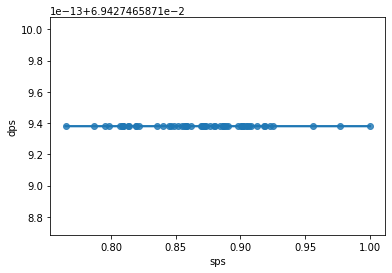

In [251]:
sns.regplot(data=df[df.dataset=='DixitRegev2016'], x='sps', y='dps')


<AxesSubplot:xlabel='sps', ylabel='dps'>

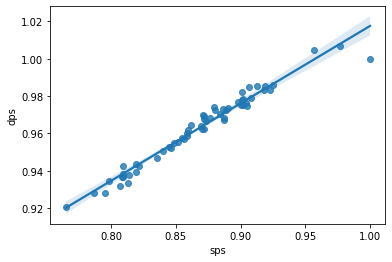

In [158]:
sns.regplot(data=df[df.dataset=='DixitRegev2016'], x='sps', y='dps')


In [228]:
list(df[df.dataset=='NormanWeissman2019\n(filtered)'].sort_values('dps').perturbation)[:3]

['BCL2L11_BAK1', 'MAML2', 'ISL2']

In [227]:
list(df[df.dataset=='NormanWeissman2019\n(filtered)'].sort_values('dps').perturbation)[-3:]

['CEBPE_SPI1', 'CEBPA', 'JUN_CEBPA']

In [181]:
from sklearn.linear_model import LinearRegression
# mask = [True]*len(df)#np.isin(df.dataset, ['TianKampmann2021\n(CRISPRi)', 'TianKampmann2021\n(CRISPRa)', 'DixitRegev2016'])
mask = ~np.isin(df.dataset, ['NormanWeissman2019\n(filtered)', 'SchraivogelSteinmetz2020\n(chromosome 11 screen)'])
X = df[mask].sps.values.reshape(-1, 1)
y = df[mask].dps.values
reg = LinearRegression().fit(X, y)

a = reg.coef_[0]
b = reg.intercept_
r = reg.score(X, y)

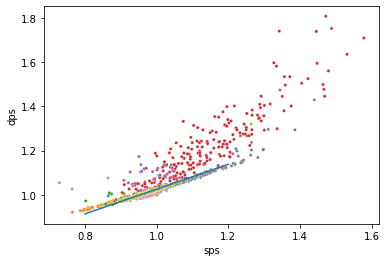

In [200]:
sns.scatterplot(data=df[df.dataset!='SchraivogelSteinmetz2020\n(chromosome 11 screen)'], x='sps', y='dps', hue='dataset', s=10, legend=False)
# pl.xlim([0.8,1.2])
# pl.ylim([0.9,1.1])
pl.plot([0.8,1.2], [a*0.8+b, a*1.2+b])
pl.show()

## DEPRECATED: pseudobulk distances

I dont get it

### without pca

In [19]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + 'ZhaoSims2021' + '.h5')
bdata = pseudo_bulk(adata, ['perturbation'])
# sc.pp.pca(bdata)
Z = bdata.X#obsm['X_pca']
from sklearn.metrics import pairwise_distances
M = pairwise_distances(Z)/Z.shape[-1]  # mean pairwise GEX distance per gene
tab=pd.DataFrame(M, index=bdata.obs.perturbation, columns=bdata.obs.perturbation)
tab = cluster_matrix(tab, 'both')
df = tab
df

perturbation    control  etoposide     Ana-12  Ispenisib  RO4929097  \
perturbation                                                          
control        0.000000   3.629887   7.726338  10.112219   6.723669   
etoposide      3.629887   0.000000  10.022079  11.859972   8.636304   
Ana-12         7.726338  10.022079   0.000000   4.986882   5.500310   
Ispenisib     10.112219  11.859972   4.986882   0.000000   6.032993   
RO4929097      6.723669   8.636304   5.500310   6.032993   0.000000   
panobinostat   6.377066   7.725365   8.436950   8.835092   5.823655   
Tazemetostat   7.627846   9.107672   7.158165   7.770849   5.625077   

perturbation  panobinostat  Tazemetostat  
perturbation                              
control           6.377066      7.627846  
etoposide         7.725365      9.107672  
Ana-12            8.436950      7.158165  
Ispenisib         8.835092      7.770849  
RO4929097         5.823655      5.625077  
panobinostat      0.000000      5.470557  
Tazemetostat      5.470557      0.000000

In [21]:
# mean std per gene
mean_std_per_dim = [np.mean(np.std(adata[adata.obs.perturbation==p].X.A, axis=0)) for p in pd.unique(adata.obs.perturbation)]

In [22]:
mean_std_per_dim

[0.12583247,
 0.12321542,
 0.12676674,
 0.11087782,
 0.111985266,
 0.11519072,
 0.11265035]

In [24]:
sc.tl.umap(adata)

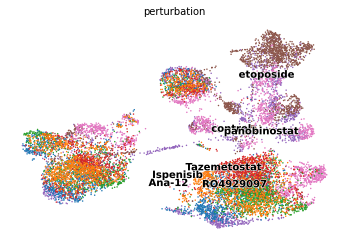

In [25]:
scv.pl.scatter(adata, color='perturbation', basis='umap')

### with pca

In [29]:
SDIR = "/fast/scratch/users/peidlis_c/perturbation_resource_paper/"
adata = sc.read(SDIR+'tmp_data_' + 'ZhaoSims2021' + '.h5')
bdata = pseudo_bulk(adata, ['perturbation'])
sc.pp.pca(bdata)
Z = bdata.obsm['X_pca']
from sklearn.metrics import pairwise_distances
M = pairwise_distances(Z)
tab=pd.DataFrame(M, index=bdata.obs.perturbation, columns=bdata.obs.perturbation)
tab = cluster_matrix(tab, 'both')
df = tab
df

perturbation        control      etoposide      Ispenisib   panobinostat  \
perturbation                                                               
control            0.000000   56008.394531  180539.468750  142927.281250   
etoposide      56008.394531       0.000000  210939.250000  159728.500000   
Ispenisib     180539.468750  210939.250000       0.000000  158044.609375   
panobinostat  142927.281250  159728.500000  158044.609375       0.000000   
Tazemetostat  120066.445312  137552.812500  132308.093750   89835.085938   
Ana-12         97275.054688  140091.140625  120691.882812  155466.906250   
RO4929097     131990.750000  164116.187500  109682.703125  125639.945312   

perturbation   Tazemetostat         Ana-12      RO4929097  
perturbation                                               
control       120066.445312   97275.054688  131990.750000  
etoposide     137552.812500  140091.140625  164116.187500  
Ispenisib     132308.093750  120691.882812  109682.703125  
panobinostat   89835.085938  155466.906250  125639.945312  
Tazemetostat       0.000000  126869.562500  118136.062500  
Ana-12        126869.562500       0.000000   98160.585938  
RO4929097     118136.062500   98160.585938       0.000000

In [134]:
Z.shape

(7, 6)

In [135]:
Y = adata.obsm['X_pca']

In [131]:
np.std(Z, axis=1).shape

(26164,)

In [24]:
mean_std_per_dim = [np.mean(np.std(adata.obsm['X_pca'][adata.obs.perturbation==p], axis=0)) for p in pd.unique(adata.obs.perturbation)]

# Spacers